In [1]:
import numpy as np
import pandas as pd

import os

In [ ]:
# !pip install twython

In [2]:
import nltk
# nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Data Preparation

In [3]:
vax_df = pd.read_csv("Datasets/vaccination_all_tweets.csv")
vax_df.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [4]:
import re
def clean(text):
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text, flags=re.I)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub("<.*?>+", "", text)
    return text

In [5]:
vax_df["text"] = vax_df["text"].apply(lambda x:clean(x))

In [6]:
sia = SIA()

scores = []
for i in range(len(vax_df["text"])):
    score = sia.polarity_scores(vax_df["text"][i])
    score = score["compound"]
    scores.append(score)
    
sentiment_score = []
for i in scores:
    if i >= 0.05:
        sentiment_score.append("Positive")
    elif i <= (-0.05):
        sentiment_score.append("Negative")
    else:
        sentiment_score.append("Neutral")

vax_df["sentiment"] = pd.Series(np.array(sentiment_score))

In [7]:
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    
    return text

vax_df["text"] = vax_df["text"].apply(lambda x:clean_text(x))

vax_df["text"]

0         same folks said daikon paste could treat a cyt...
1         while the world has been on the wrong side of ...
2         coronavirus sputnikv astrazeneca pfizerbiontec...
3         facts are immutable senator even when youre no...
4         explain to me again why we need a vaccine bori...
                                ...                        
228202     urban bengaluru covidvaccine availability for...
228203     bbmp bengaluru covidvaccine availability for ...
228204     urban bengaluru covidvaccine availability for...
228205    they promote their vaccines leaving out the st...
228206     urban bengaluru covidvaccine availability for...
Name: text, Length: 228207, dtype: object

In [8]:
vax_df = vax_df.dropna()

vax = vax_df.drop(["user_name","user_description","user_created","user_followers","user_friends","user_favourites","source","is_retweet"],axis=1)

In [9]:
vax.head()

id                user_location  user_verified  \
0   1340539111971516416    La Crescenta-Montrose, CA          False   
2   1337858199140118533                     Your Bed          False   
6   1337851215875608579  Austria, Ukraine and Kosovo          False   
9   1337842295857623042                    Islamabad          False   
10  1337841934170255365                Turkey-Israel          False   

                   date                                               text  \
0   2020-12-20 06:06:44  same folks said daikon paste could treat a cyt...   
2   2020-12-12 20:33:45  coronavirus sputnikv astrazeneca pfizerbiontec...   
6   2020-12-12 20:06:00  it is a bit sad to claim the fame for success ...   
9   2020-12-12 19:30:33  covidvaccine states will start getting  monday...   
10  2020-12-12 19:29:07  while deaths are closing in on the  mark milli...   

                                             hashtags  retweets  favorites  \
0                                  ['PfizerBioNTech']         0          0   
2   ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...         0          0   
6                                     ['vaccination']         0          4   
9   ['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...         0          0   
10                      ['PfizerBioNTech', 'Vaccine']         0          0   

   sentiment  
0   Positive  
2   Positive  
6   Positive  
9    Neutral  
10   Neutral

In [10]:
totals = vax.groupby("sentiment").count()["text"].reset_index().sort_values(by="text", ascending=False)

totals.style.background_gradient(cmap="RdYlBu")

# Training the model

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r"[a-zA-Z0-9]+")

cv = CountVectorizer(stop_words="english",ngram_range = (1,1),tokenizer = token.tokenize)
text_count = cv.fit_transform(vax["text"])

C:\Users\Tilda\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
print(text_count)

  (0, 19961)	1
  (0, 47425)	1
  (0, 13081)	1
  (0, 40532)	1
  (0, 56071)	1
  (0, 13018)	1
  (0, 52206)	1
  (0, 41230)	1
  (1, 41230)	1
  (1, 11625)	1
  (1, 51459)	1
  (1, 3724)	1
  (1, 34998)	1
  (1, 47143)	1
  (1, 58177)	1
  (1, 12483)	1
  (1, 61761)	1
  (2, 6198)	1
  (2, 47305)	1
  (2, 9944)	1
  (2, 18815)	1
  (2, 52532)	1
  (2, 58088)	1
  (2, 40631)	1
  (2, 10844)	1
  :	:
  (116051, 5058)	1
  (116052, 12246)	1
  (116052, 15610)	1
  (116052, 20376)	1
  (116052, 12329)	1
  (116052, 4119)	1
  (116052, 57644)	1
  (116052, 40039)	1
  (116052, 5470)	1
  (116052, 50404)	2
  (116053, 51459)	1
  (116053, 58177)	1
  (116053, 58425)	1
  (116053, 30769)	1
  (116053, 47129)	1
  (116053, 52352)	1
  (116053, 43347)	1
  (116054, 12246)	1
  (116054, 20376)	1
  (116054, 12329)	1
  (116054, 4119)	1
  (116054, 57644)	1
  (116054, 40039)	1
  (116054, 5470)	1
  (116054, 50404)	2


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_count, vax["sentiment"], test_size=0.25, random_state=5)

In [14]:
print(X_train)

  (0, 47425)	1
  (0, 45053)	1
  (0, 50047)	1
  (0, 14277)	1
  (0, 27555)	1
  (0, 22295)	1
  (0, 30267)	1
  (0, 24470)	1
  (0, 43221)	1
  (0, 909)	1
  (0, 805)	1
  (0, 30599)	1
  (0, 62075)	1
  (0, 51658)	1
  (1, 34998)	1
  (1, 55643)	1
  (1, 50920)	1
  (1, 36075)	1
  (1, 6606)	1
  (1, 48537)	1
  (1, 56207)	1
  (1, 48453)	1
  (1, 44686)	1
  (1, 34389)	1
  (1, 33648)	1
  :	:
  (87038, 31712)	1
  (87038, 39088)	1
  (87038, 31710)	1
  (87039, 34998)	1
  (87039, 24663)	1
  (87039, 15610)	1
  (87039, 12891)	1
  (87039, 42395)	1
  (87039, 469)	1
  (87039, 35081)	1
  (87039, 6606)	1
  (87039, 19307)	1
  (87039, 9392)	1
  (87039, 47076)	1
  (87039, 30957)	1
  (87040, 41230)	1
  (87040, 58177)	1
  (87040, 57993)	1
  (87040, 12020)	1
  (87040, 55455)	1
  (87040, 31540)	1
  (87040, 8674)	1
  (87040, 60372)	1
  (87040, 22153)	1
  (87040, 20698)	1


In [15]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

MultinomialNB()

### Prediction

In [16]:
from sklearn import metrics
predictions = mnb.predict(X_test)
accuracy_score = metrics.accuracy_score(predictions, Y_test)

print(str("{:04.2f}".format(accuracy_score*100))+"%")

79.84%


In [17]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

cnb = ComplementNB()
bnb = BernoulliNB()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(vax["text"])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(text_counts, vax["sentiment"], test_size=0.25, random_state=5)

mnb.fit(x_train, y_train)
mnb_accuracy_score = metrics.accuracy_score(mnb.predict(x_test), y_test)
print("MNB accuracy score: "+str("{:04.2f}".format(mnb_accuracy_score*100))+"%")

cnb.fit(x_train, y_train)
cnb_accuracy_score = metrics.accuracy_score(cnb.predict(x_test), y_test)
print("CNB accuracy score: "+str("{:04.2f}".format(cnb_accuracy_score*100))+"%")

bnb.fit(x_train, y_train)
bnb_accuracy_score = metrics.accuracy_score(bnb.predict(x_test), y_test)
print("BNB accuracy score: "+str("{:04.2f}".format(bnb_accuracy_score*100))+"%")

MNB accuracy score: 77.35%
CNB accuracy score: 79.53%
BNB accuracy score: 80.46%


# Data Analysis and Visualization

In [20]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

In [63]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [22]:
df_pos = vax[vax["sentiment"] == "Positive"].reset_index()
df_neg = vax[vax["sentiment"] == "Negative"].reset_index()
df_neu = vax[vax["sentiment"] == "Neutral"].reset_index()

## Distrubution of Sentiments Chart

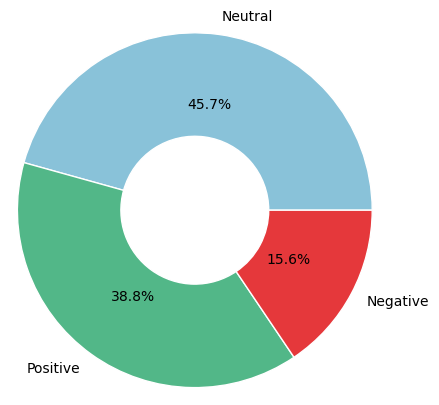

In [23]:
percent_class=totals.text
labels= totals.sentiment

colors = ["#89c2d9","#52b788","#e5383b"]

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.7, edgecolor='white') 

plt.show()

## Wordclouds

Text(0.5, 1.0, 'Neutral Sentiment')

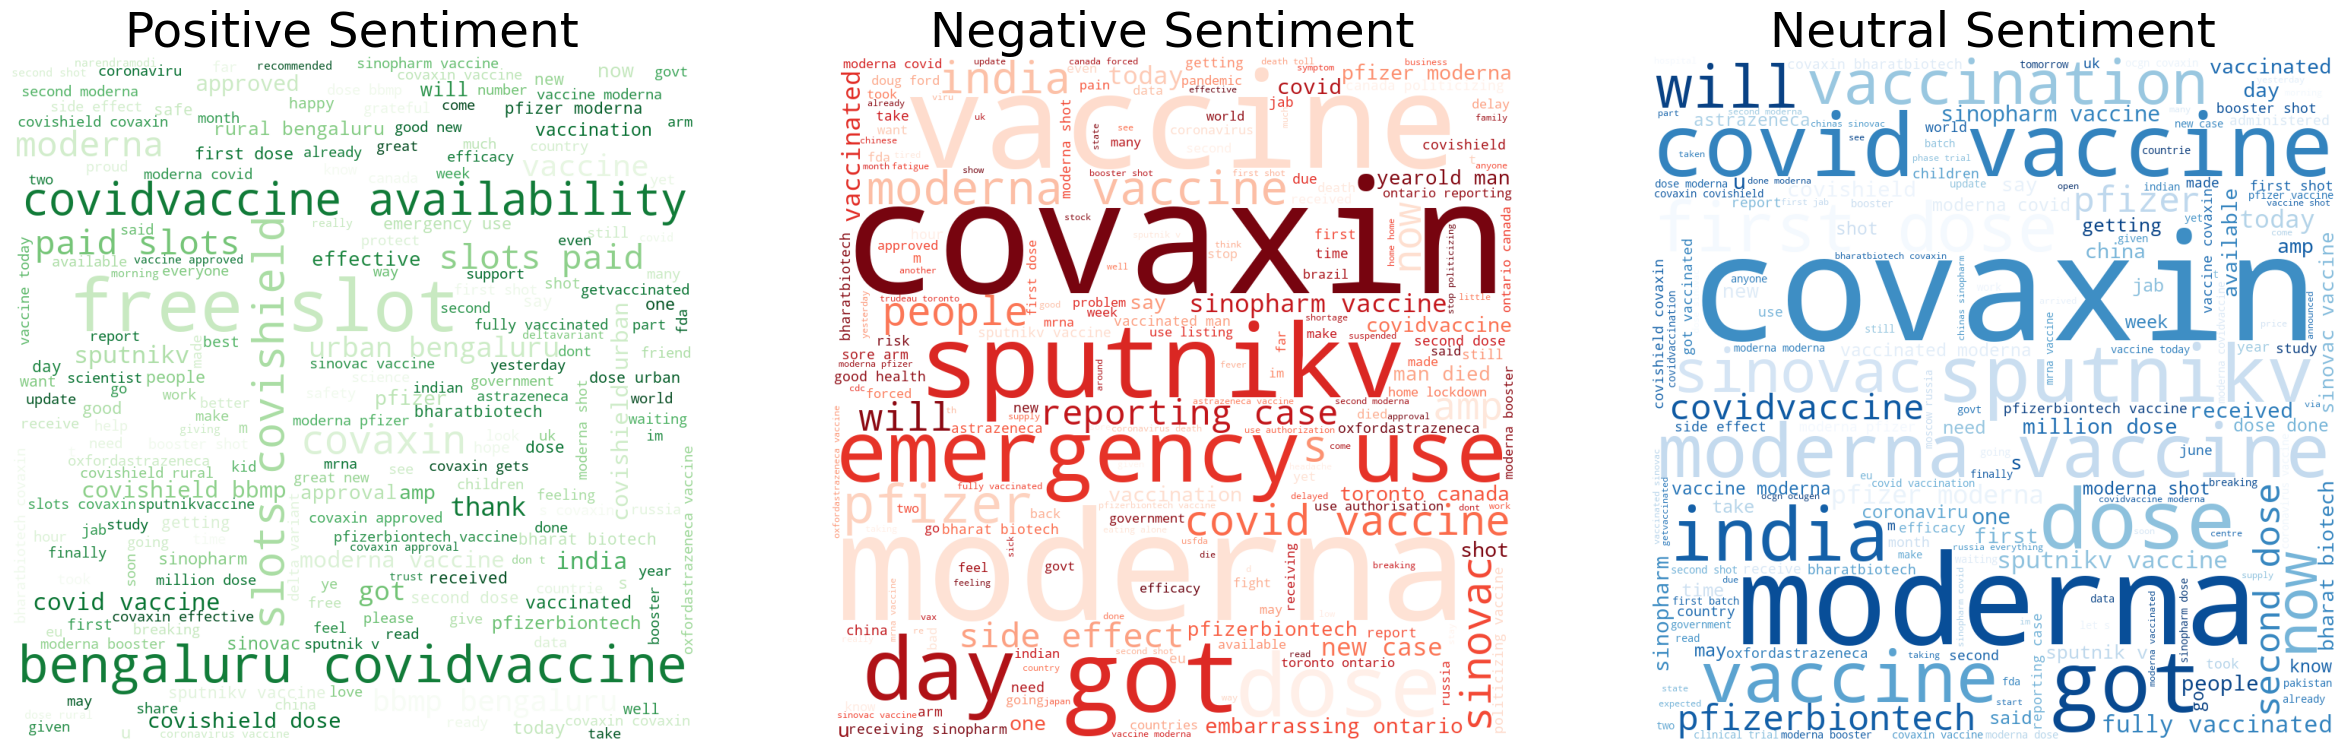

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

# Positive sentiment wordcloud
comment_words = ""
stopwords = set(STOPWORDS)

for val in df_pos.text:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    
pos_wordcloud = WordCloud(width=900, height=900,
                          background_color="white",
                          colormap="Greens",
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)
ax1.imshow(pos_wordcloud)
ax1.axis("off")
ax1.set_title("Positive Sentiment", fontsize=35)

# Negative sentiment wordcloud
comment_words = ""

for val in df_neg.text:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    
neg_wordcloud = WordCloud(width=900, height=900,
                          background_color="white",
                          colormap="Reds",
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)
ax2.imshow(neg_wordcloud)
ax2.axis("off")
ax2.set_title("Negative Sentiment", fontsize=35)

# Neutral sentiment wordcloud
comment_words = ""

for val in df_neu.text:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    
neu_wordcloud = WordCloud(width=900, height=900,
                          background_color="white",
                          colormap="Blues",
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)
ax3.imshow(neu_wordcloud)
ax3.axis("off")
ax3.set_title("Neutral Sentiment", fontsize=35)

# N-grams

In [25]:
import unicodedata

def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english") 
    text = (unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore").lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [26]:
import nltk
# nltk.download("wordnet")

In [27]:
pos_tweets = basic_clean("".join(str(df_pos["text"].tolist())))

## Positive Sentiment N-grams

Text(0.5, 1.0, 'Positive sentiment unigram')

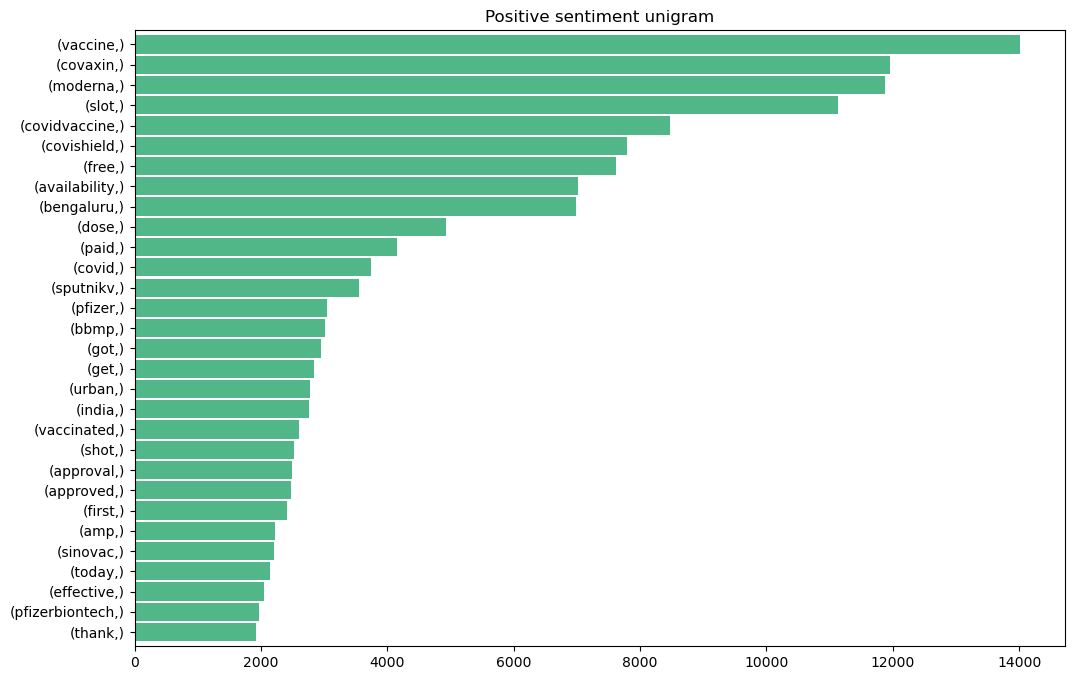

In [28]:
positive_unigram = (pd.Series(nltk.ngrams(pos_tweets, 1)).value_counts())[:30]
positive_unigram.sort_values().plot.barh(color="#52b788", width=.9, figsize=(12, 8))

plt.title("Positive sentiment unigram")

Text(0.5, 1.0, 'Positive sentiment bigram')

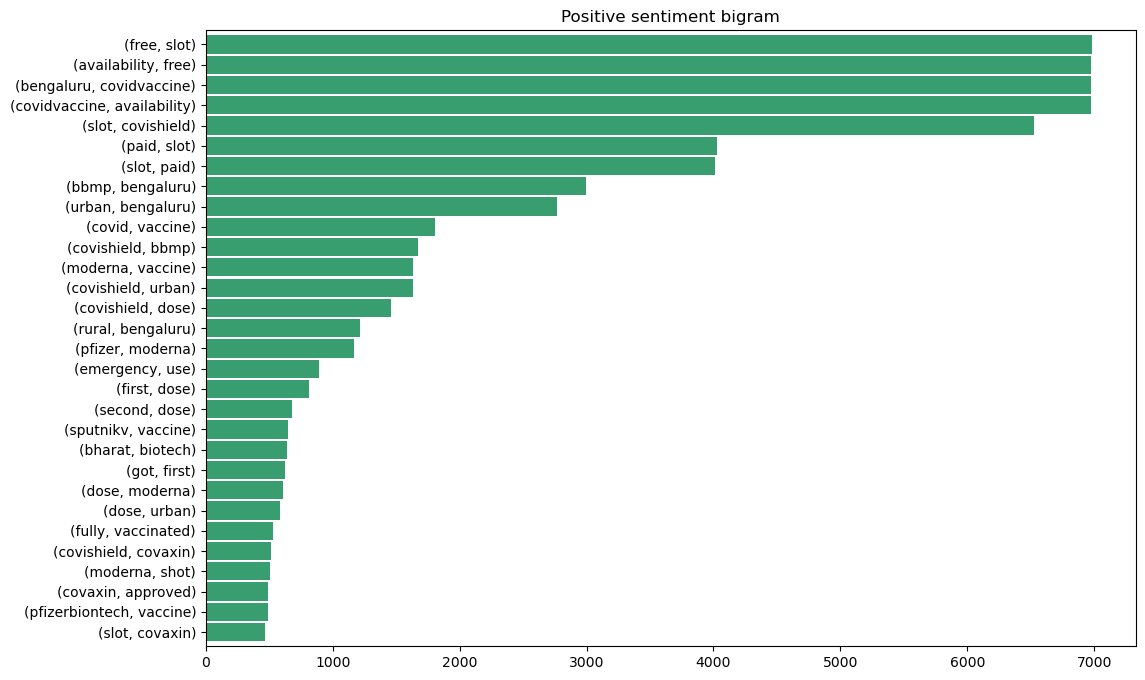

In [29]:
positive_bigram = (pd.Series(nltk.ngrams(pos_tweets, 2)).value_counts())[:30]
positive_bigram.sort_values().plot.barh(color="#399e6f", width=.9, figsize=(12, 8))

plt.title("Positive sentiment bigram")

Text(0.5, 1.0, 'Positive sentiment trigram')

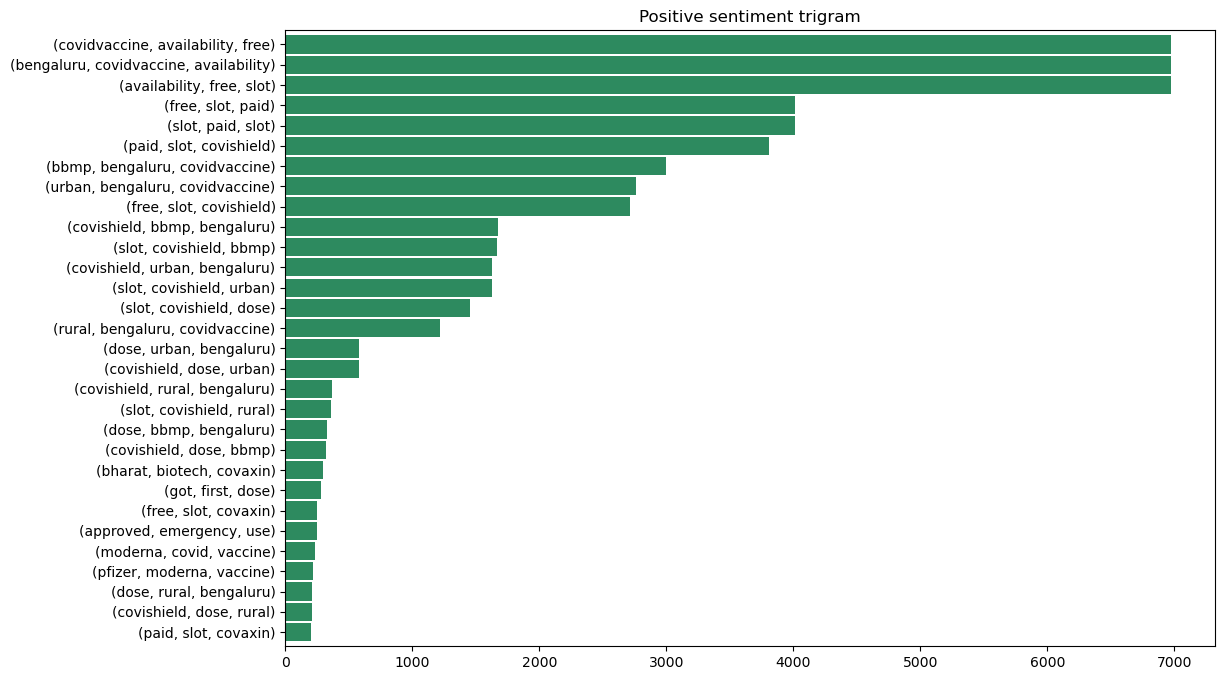

In [30]:
positive_trigram = (pd.Series(nltk.ngrams(pos_tweets, 3)).value_counts())[:30]
positive_trigram.sort_values().plot.barh(color="#2d8a5f", width=.9, figsize=(12, 8))

plt.title("Positive sentiment trigram")

In [31]:
neg_tweets = basic_clean("".join(str(df_neg["text"].tolist())))

## Negative Sentiment N-grams

Text(0.5, 1.0, 'Negative sentiment unigram')

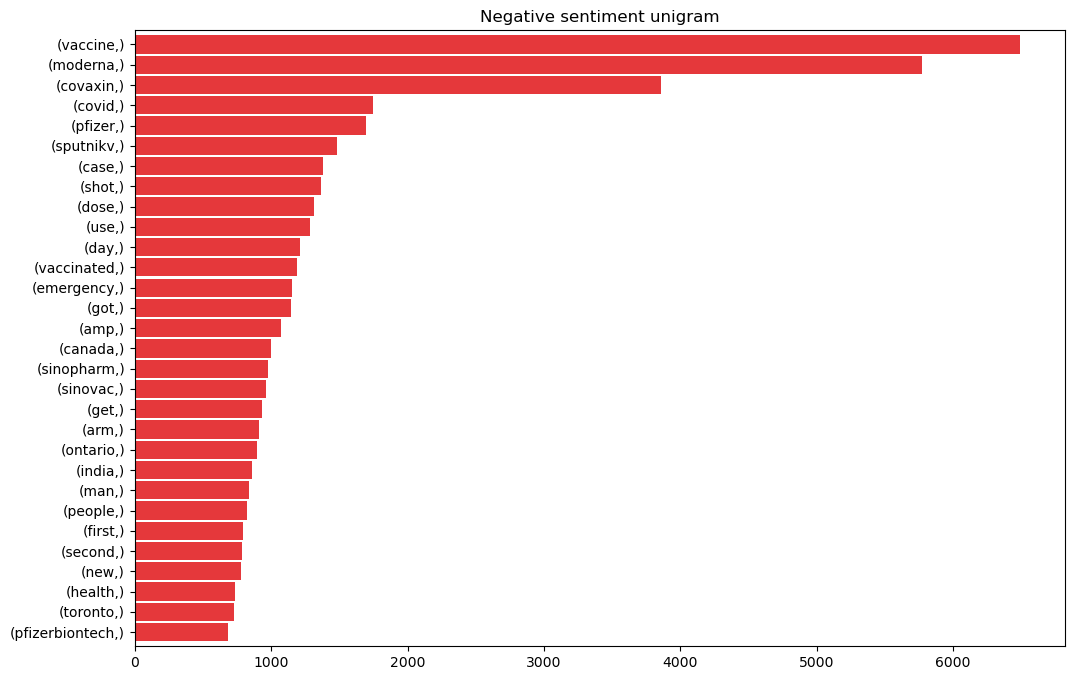

In [32]:
negative_unigram = (pd.Series(nltk.ngrams(neg_tweets, 1)).value_counts())[:30]
negative_unigram.sort_values().plot.barh(color="#e5383b", width=.9, figsize=(12, 8))

plt.title("Negative sentiment unigram")

Text(0.5, 1.0, 'Negative sentiment bigram')

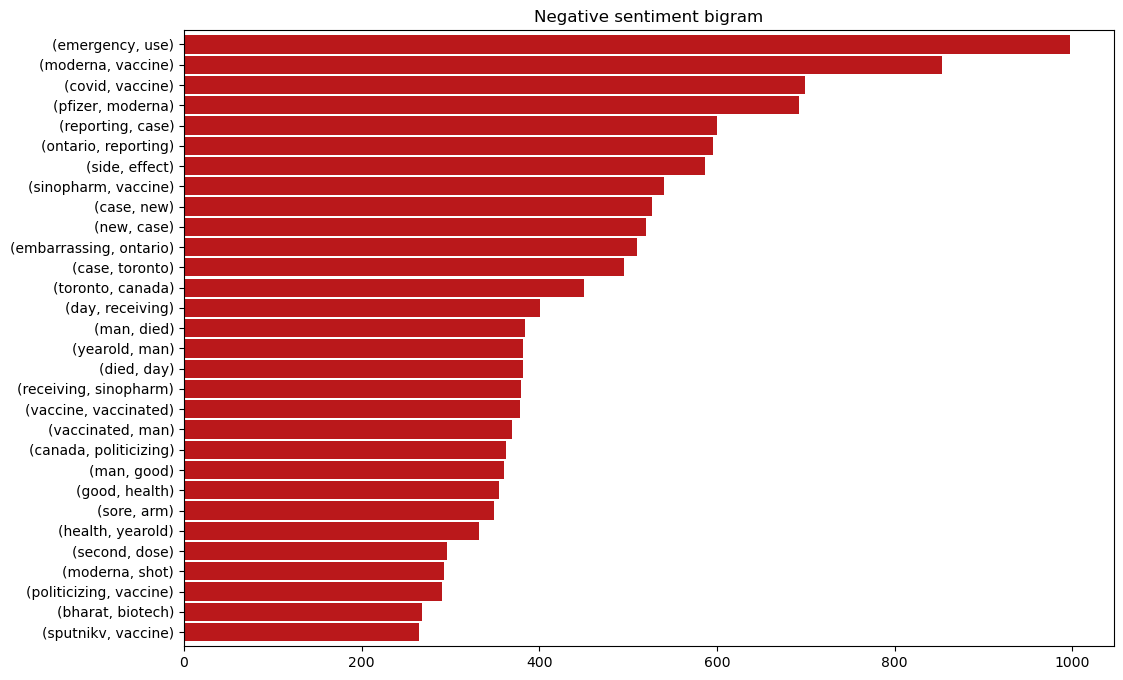

In [33]:
negative_bigram = (pd.Series(nltk.ngrams(neg_tweets, 2)).value_counts())[:30]
negative_bigram.sort_values().plot.barh(color="#ba181b", width=.9, figsize=(12, 8))

plt.title("Negative sentiment bigram")

Text(0.5, 1.0, 'Negative sentiment trigram')

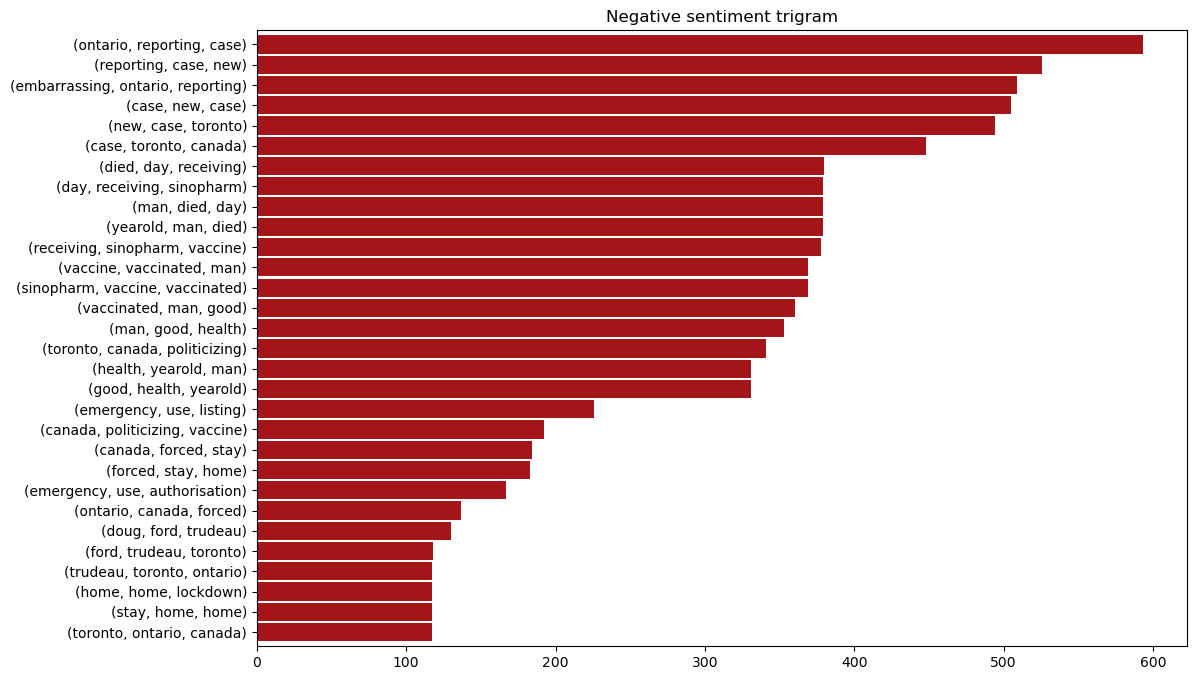

In [34]:
negative_trigram = (pd.Series(nltk.ngrams(neg_tweets, 3)).value_counts())[:30]
negative_trigram.sort_values().plot.barh(color="#a4161a", width=.9, figsize=(12, 8))

plt.title("Negative sentiment trigram")

In [35]:
neu_tweets = basic_clean("".join(str(df_neu["text"].tolist())))

## Neutral Sentiment N-grams

Text(0.5, 1.0, 'Neutral sentiment unigram')

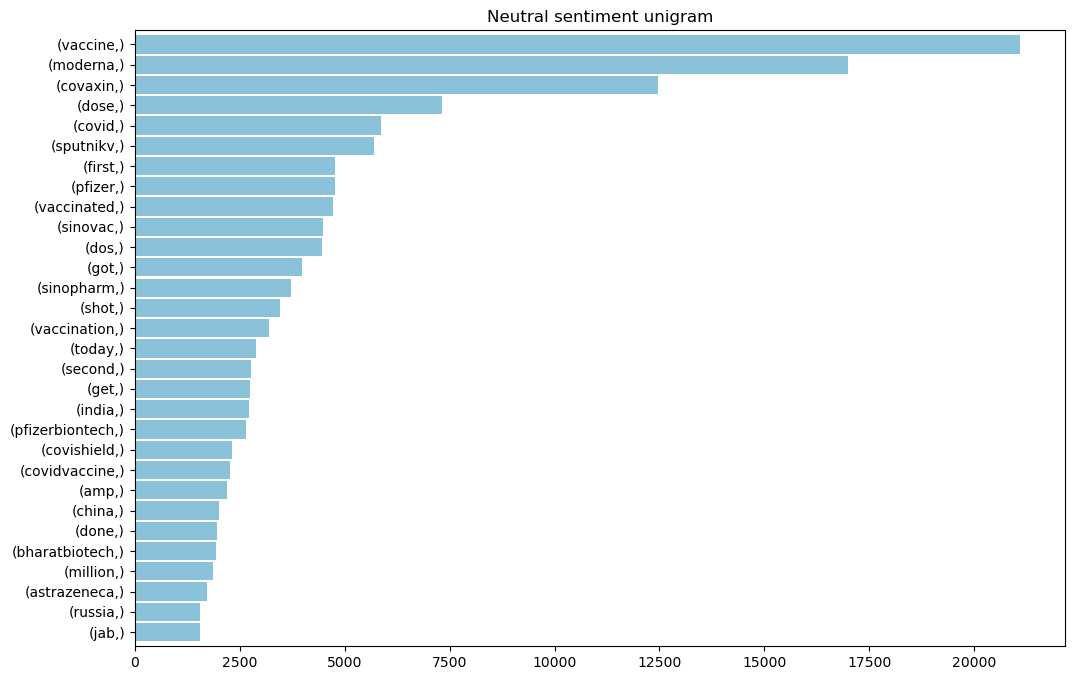

In [36]:
neutral_unigram = (pd.Series(nltk.ngrams(neu_tweets, 1)).value_counts())[:30]
neutral_unigram.sort_values().plot.barh(color="#89c2d9", width=.9, figsize=(12, 8))

plt.title("Neutral sentiment unigram")

Text(0.5, 1.0, 'Neutral sentiment bigram')

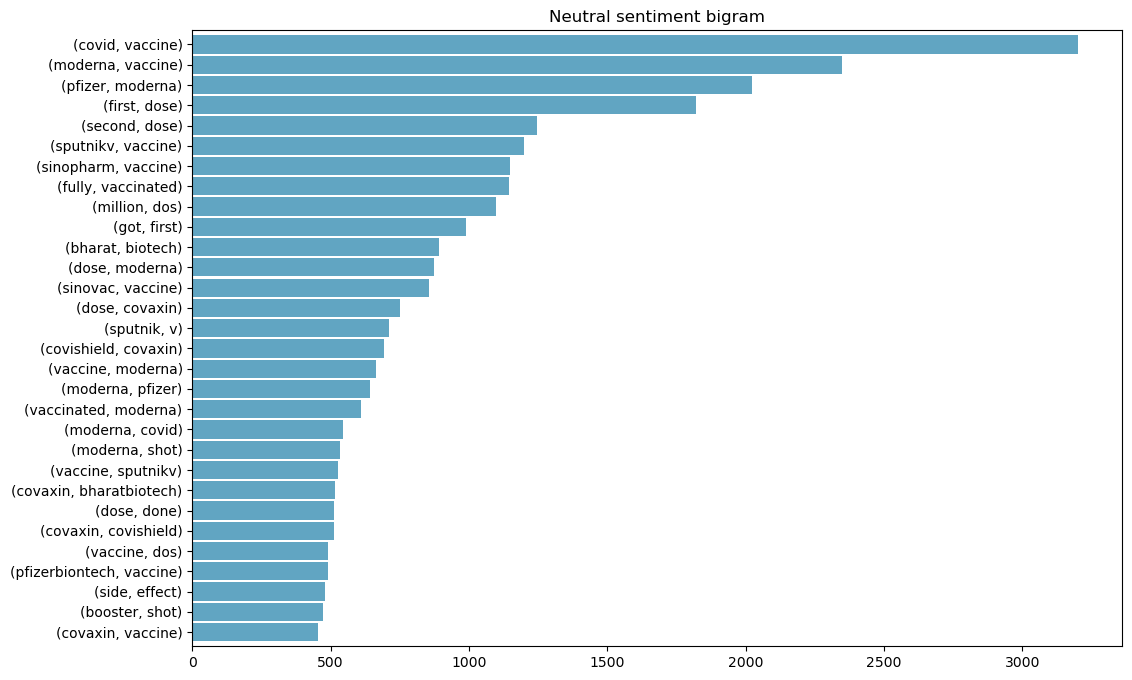

In [37]:
neutral_bigram = (pd.Series(nltk.ngrams(neu_tweets, 2)).value_counts())[:30]
neutral_bigram.sort_values().plot.barh(color="#61a5c2", width=.9, figsize=(12, 8))

plt.title("Neutral sentiment bigram")

Text(0.5, 1.0, 'Neutral sentiment trigram')

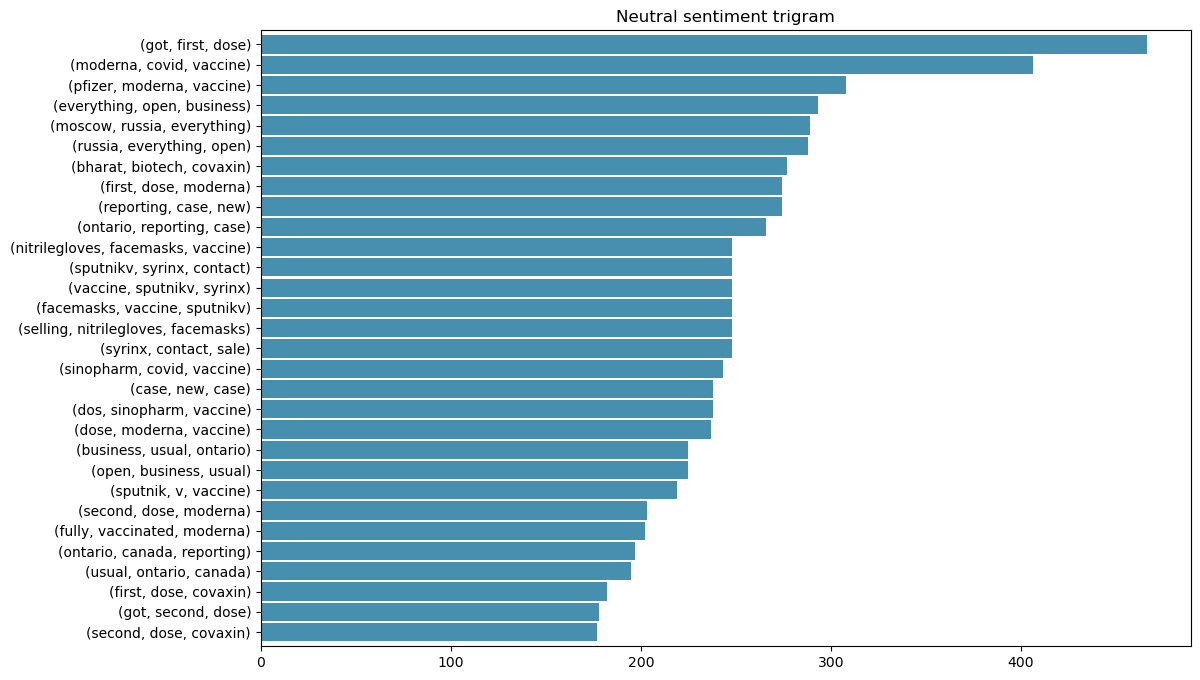

In [38]:
neutral_trigram = (pd.Series(nltk.ngrams(neu_tweets, 3)).value_counts())[:30]
neutral_trigram.sort_values().plot.barh(color="#468faf", width=.9, figsize=(12, 8))

plt.title("Neutral sentiment trigram")

# Variance with Time for Vaccines

In [39]:
import time
import datetime

vax["date"] = pd.to_datetime(vax["date"], errors="coerce").dt.date

vax.head()

id                user_location  user_verified  \
0   1340539111971516416    La Crescenta-Montrose, CA          False   
2   1337858199140118533                     Your Bed          False   
6   1337851215875608579  Austria, Ukraine and Kosovo          False   
9   1337842295857623042                    Islamabad          False   
10  1337841934170255365                Turkey-Israel          False   

          date                                               text  \
0   2020-12-20  same folks said daikon paste could treat a cyt...   
2   2020-12-12  coronavirus sputnikv astrazeneca pfizerbiontec...   
6   2020-12-12  it is a bit sad to claim the fame for success ...   
9   2020-12-12  covidvaccine states will start getting  monday...   
10  2020-12-12  while deaths are closing in on the  mark milli...   

                                             hashtags  retweets  favorites  \
0                                  ['PfizerBioNTech']         0          0   
2   ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...         0          0   
6                                     ['vaccination']         0          4   
9   ['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...         0          0   
10                      ['PfizerBioNTech', 'Vaccine']         0          0   

   sentiment  
0   Positive  
2   Positive  
6   Positive  
9    Neutral  
10   Neutral

In [40]:
vax["sentiment"] = vax["sentiment"].map( {'Positive':1 , 'Neutral':0, 'Negative':-1} )

In [41]:
all_vax = ["covaxin", "sinopharm", "sinovac", "moderna", "pfizer", "biontech", "oxford", "astrazeneca", "sputnik"]

vax_sentiment = pd.DataFrame()
vax_sentiment["Vaccine"]=all_vax
sentiments=list()

In [42]:
import seaborn as sns

def vax_time_variance(vacc) :
    if vacc=="all":
        vacc=vax
    else:   
        vacc=vax[vax["text"].str.lower().str.contains(vacc)]
        sentiments.append(vacc.sentiment.mean())

    temp=pd.DataFrame()
    temp["date"] = sorted(vacc["date"].unique())
    senti=list()

    for date in temp["date"]:
        senti.append(vacc[vacc["date"]==date].sentiment.mean())

    temp["sentiment"]=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x="date",y="sentiment", data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("sentiment",size=16)
    axs.set_title("Variance of Sentiment with Time",size=24)
    axs.grid()

## All Vaccines

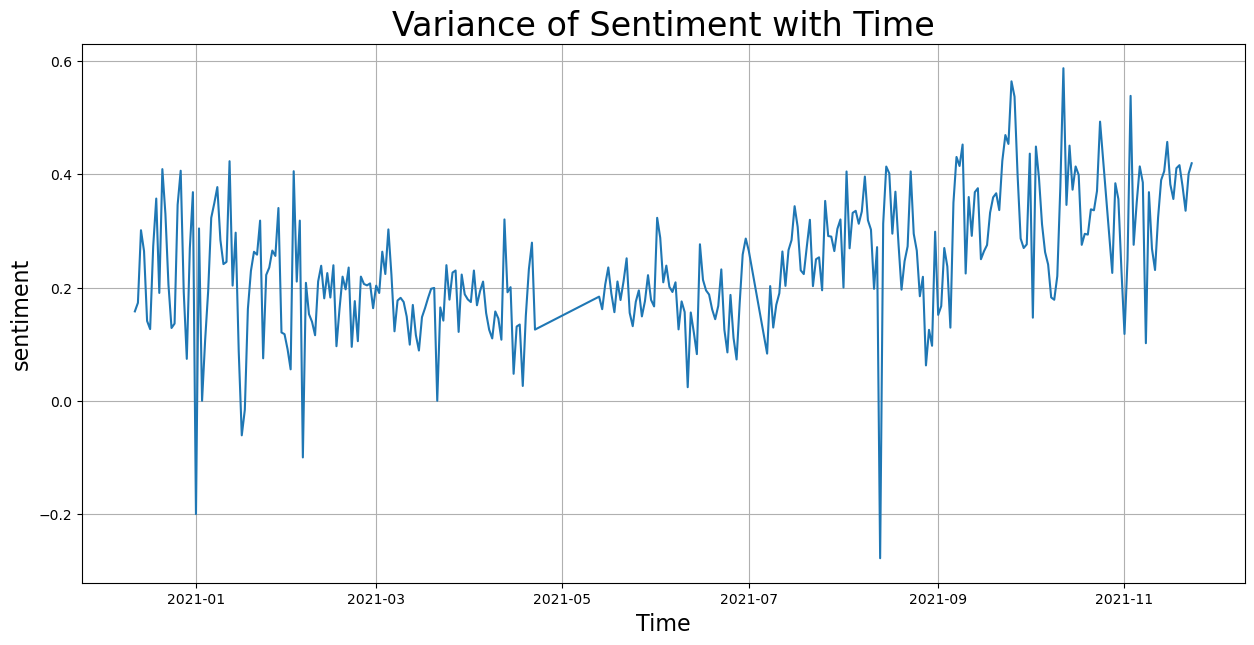

In [43]:
vax_time_variance("all")

## Covaxin

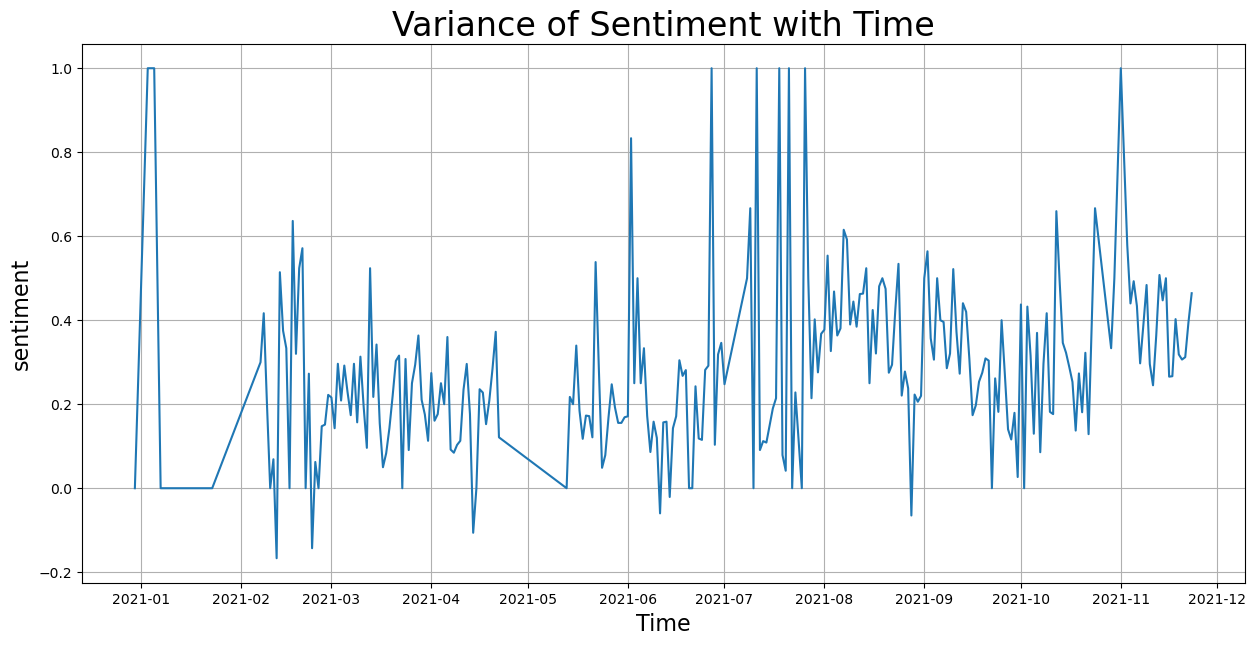

In [44]:
vax_time_variance("covaxin")

## Sinopharm

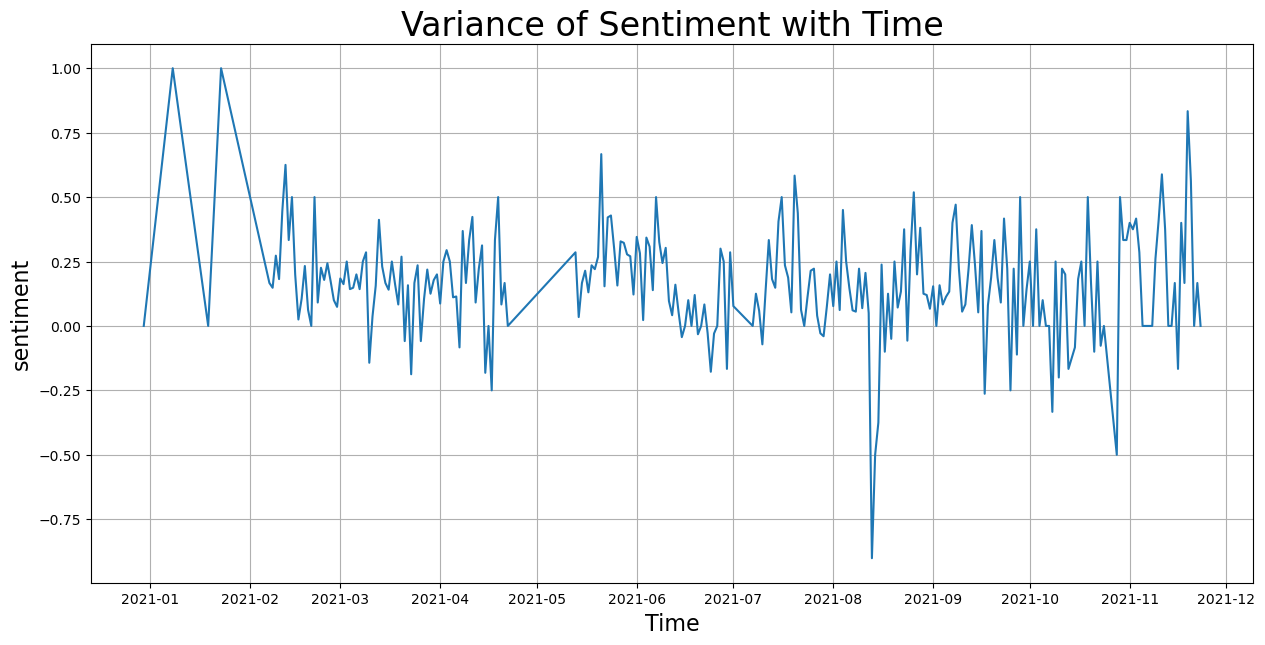

In [45]:
vax_time_variance("sinopharm")

## Sinovac

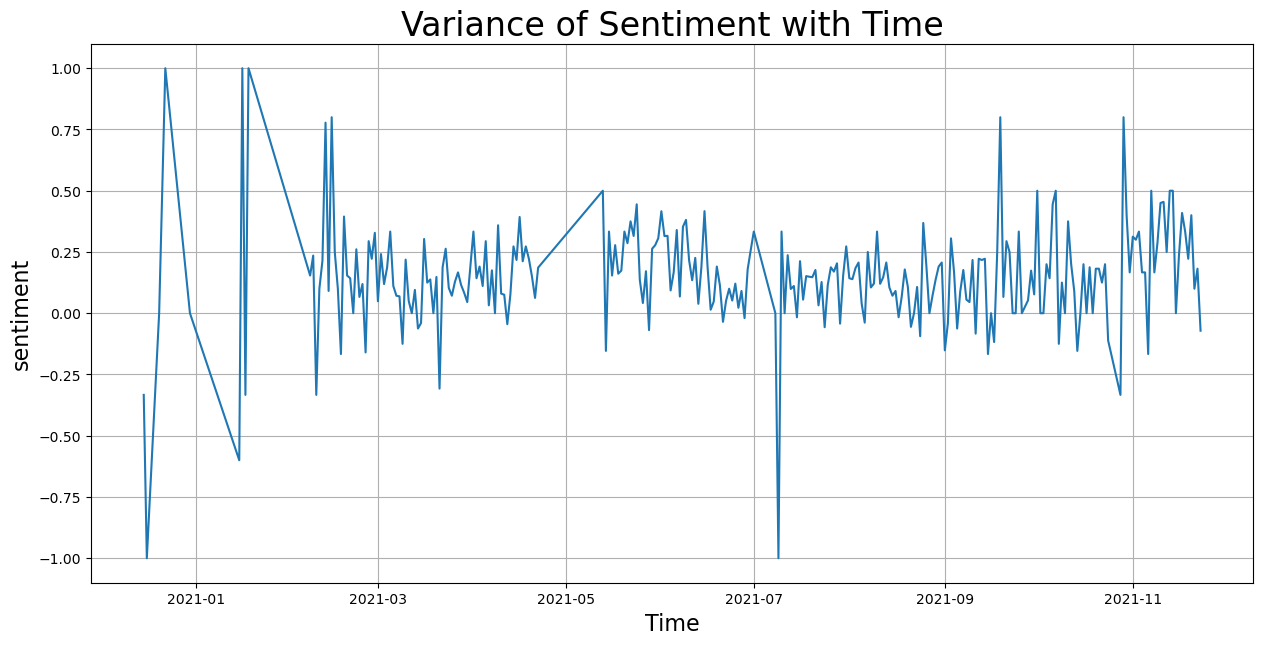

In [46]:
vax_time_variance("sinovac")

## Moderna 

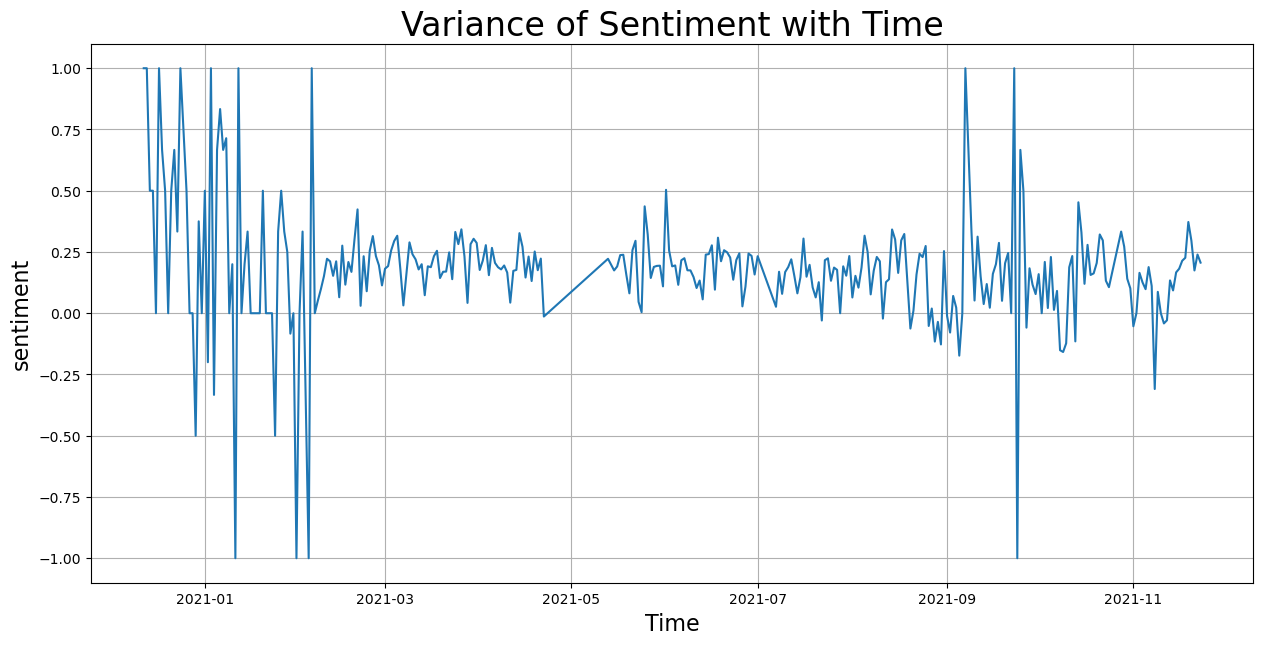

In [47]:
vax_time_variance("moderna")

## Pfizer

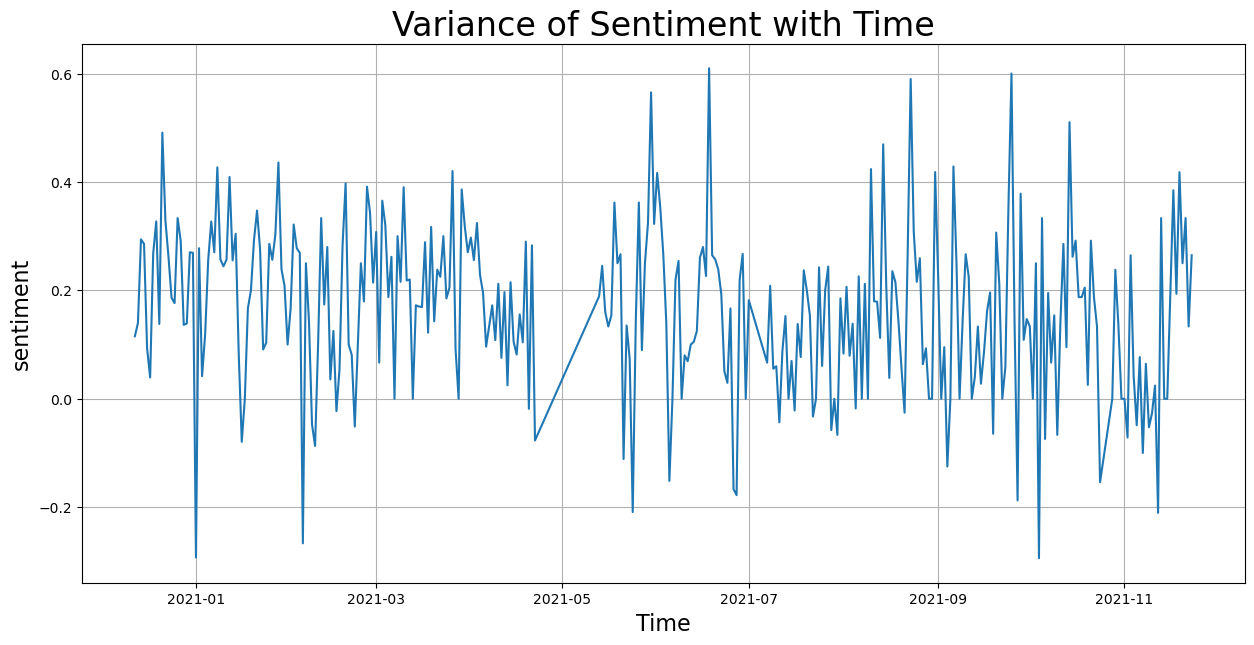

In [48]:
vax_time_variance("pfizer")

## Biontech

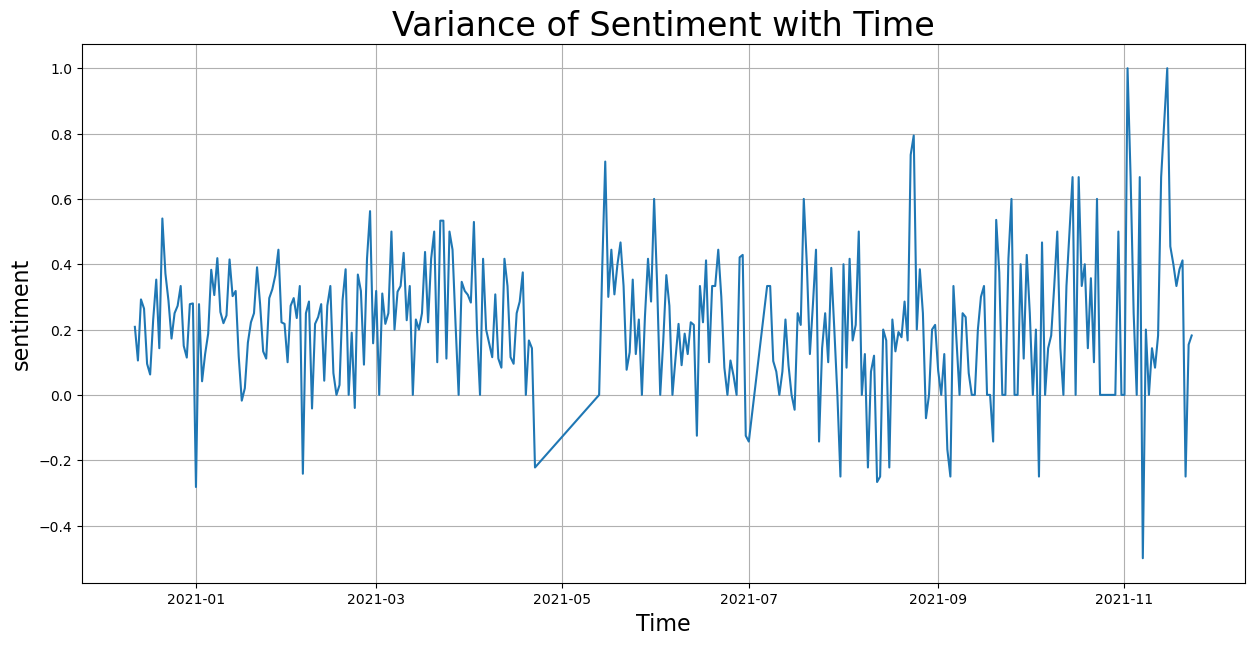

In [49]:
vax_time_variance("biontech")

## Oxford

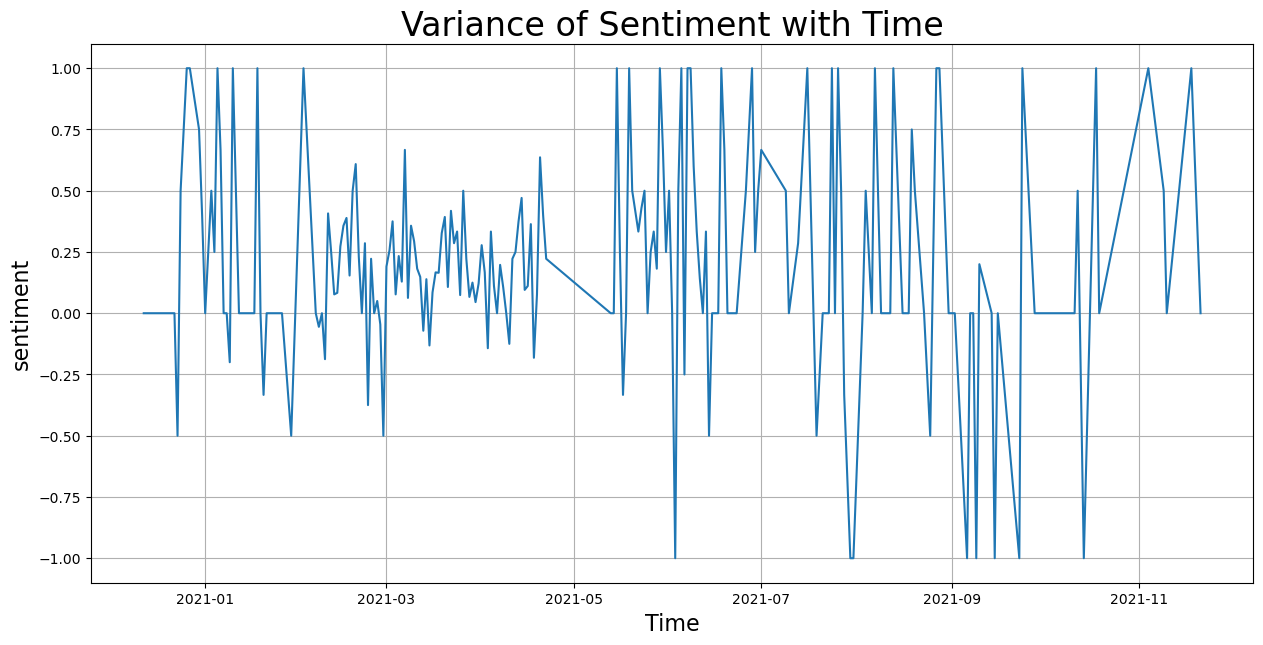

In [50]:
vax_time_variance("oxford")

## Astrazeneca

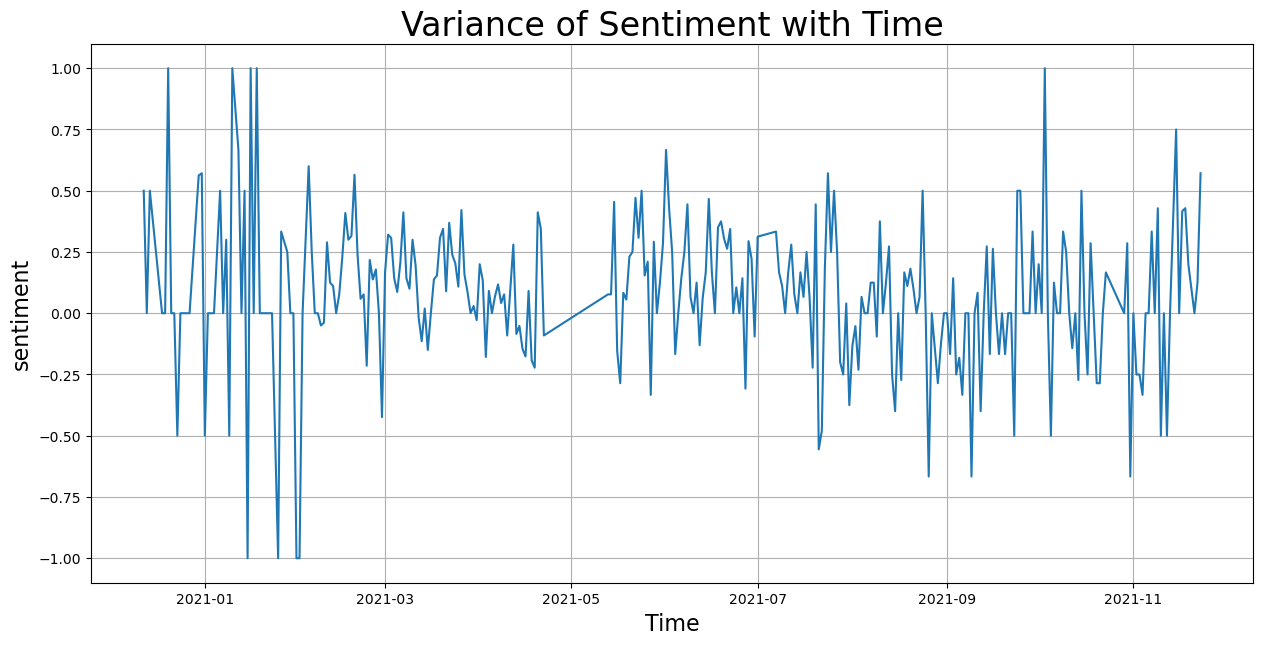

In [51]:
vax_time_variance("astrazeneca")

## Sputnik

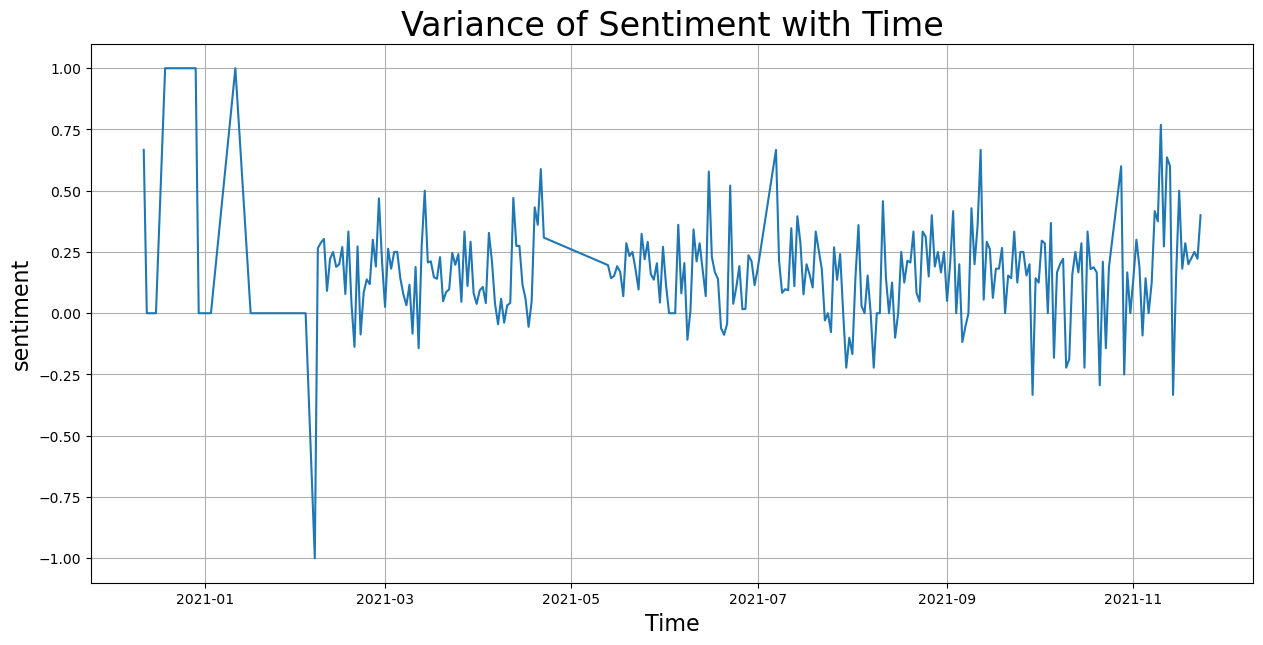

In [52]:
vax_time_variance("sputnik")

# Variance with Time in Different Countries

In [53]:
def country_time_variance(country) :
    count=vax[vax["user_location"].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp["date"] = sorted(count["date"].unique())
    senti=list()

    for date in temp["date"]:
        senti.append(count[count["date"]==date].sentiment.mean())

    temp["sentiment"]=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y="sentiment", data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("sentiment",size=16)
    axs.set_title("Variance of Sentiment with Time",size=24)
    axs.grid()

## Sweden

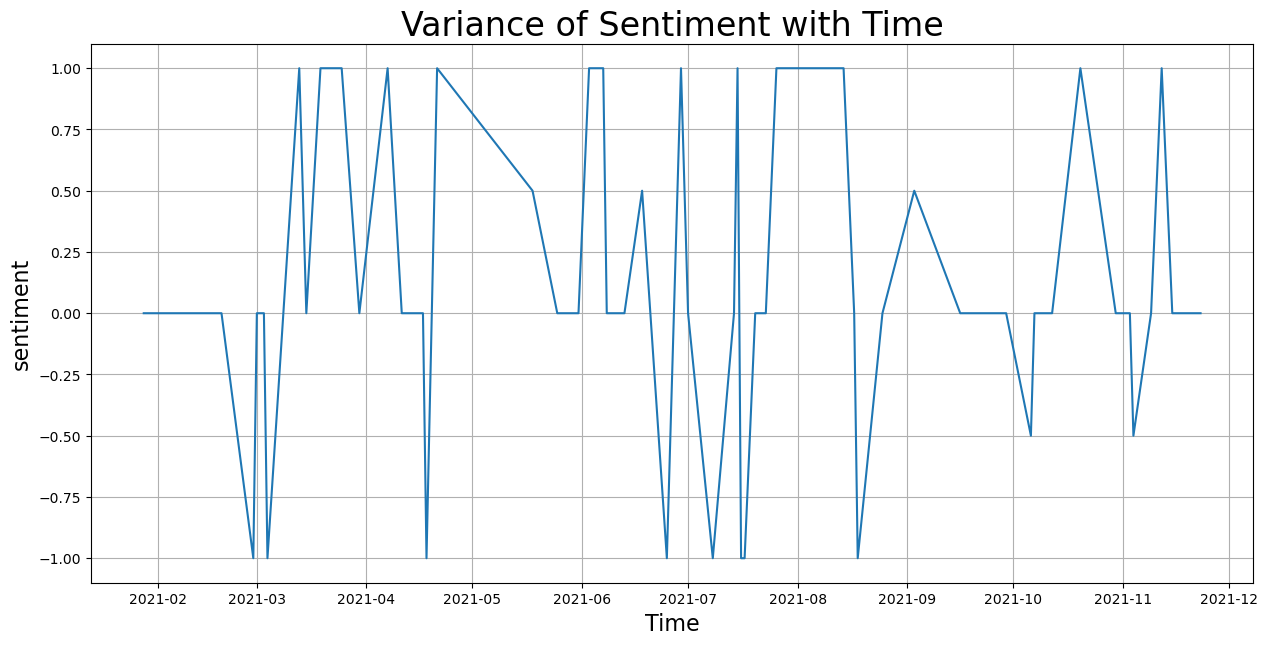

In [54]:
country_time_variance("sweden")

## USA

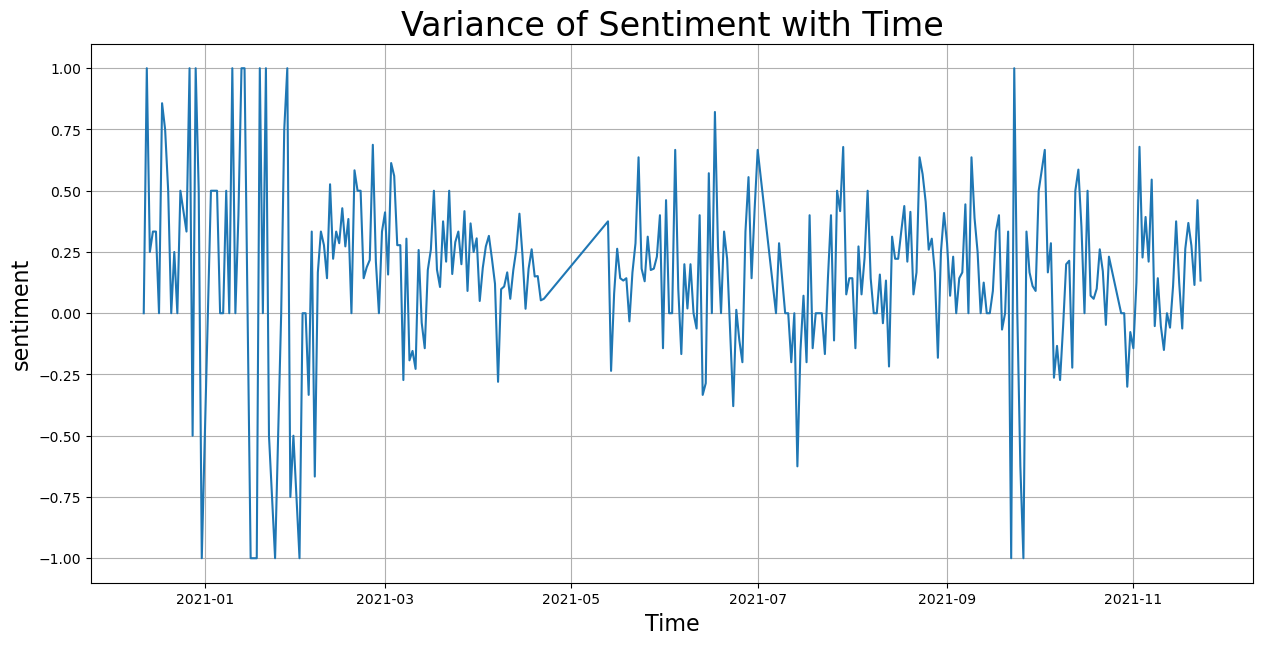

In [55]:
country_time_variance("usa")

## UK

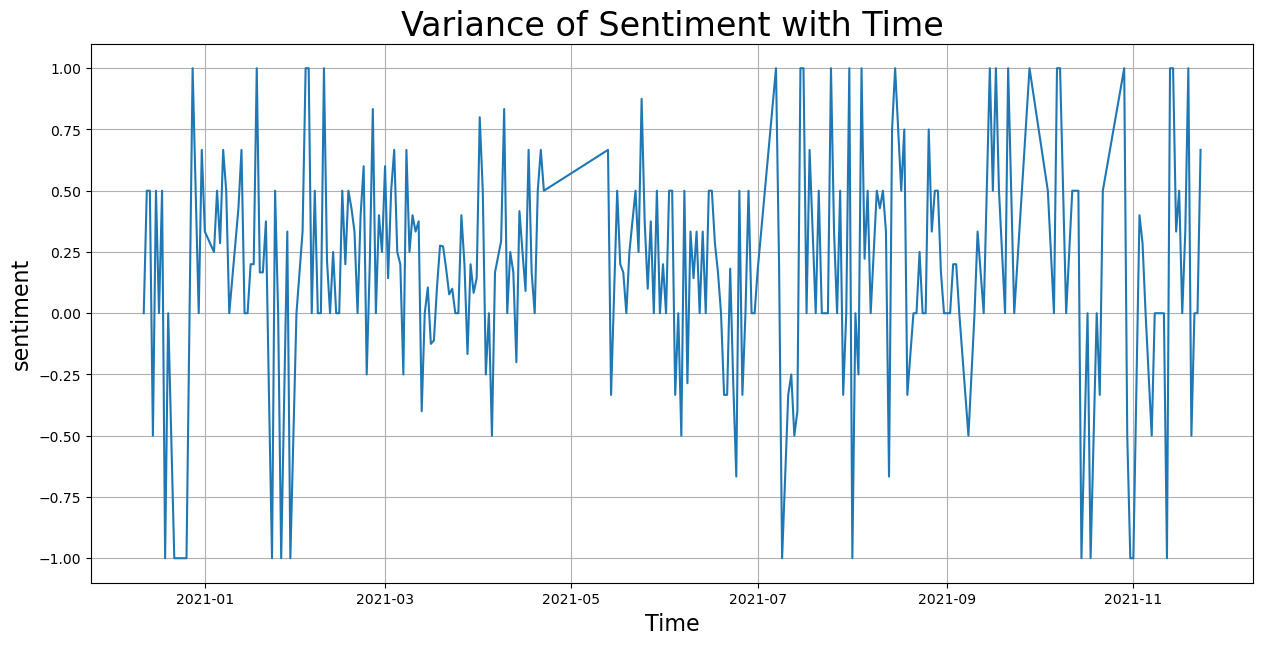

In [56]:
country_time_variance("uk")

## Norway

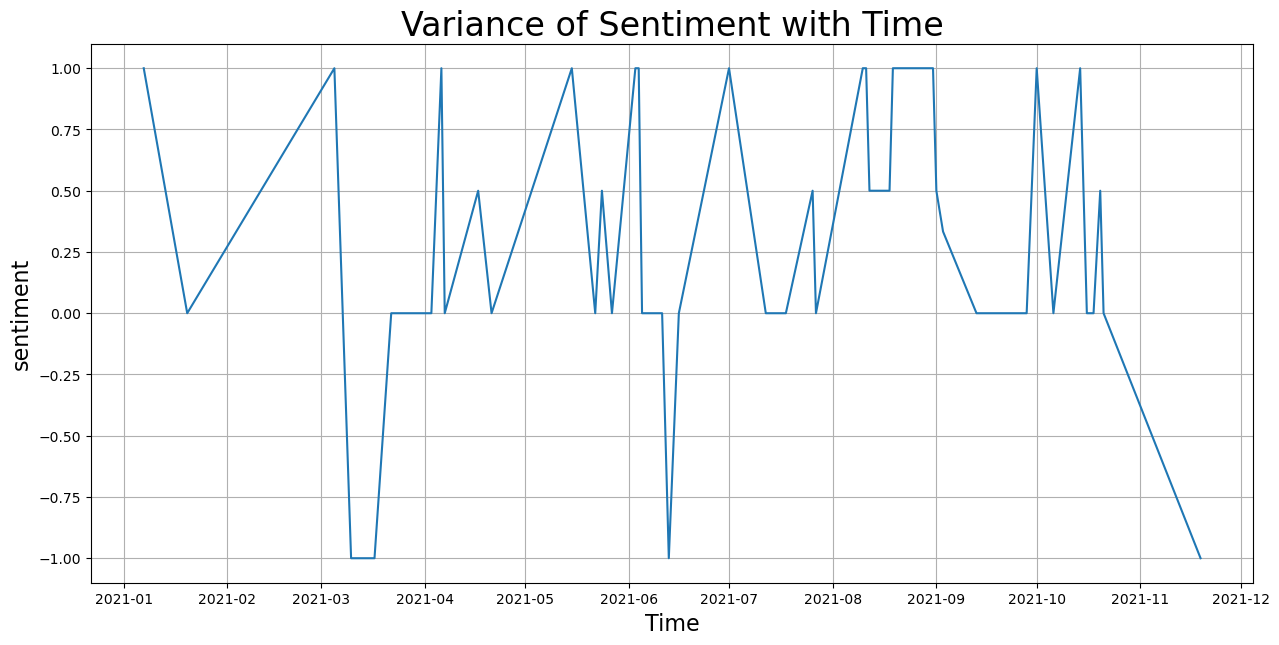

In [57]:
country_time_variance("norway")

## Finland

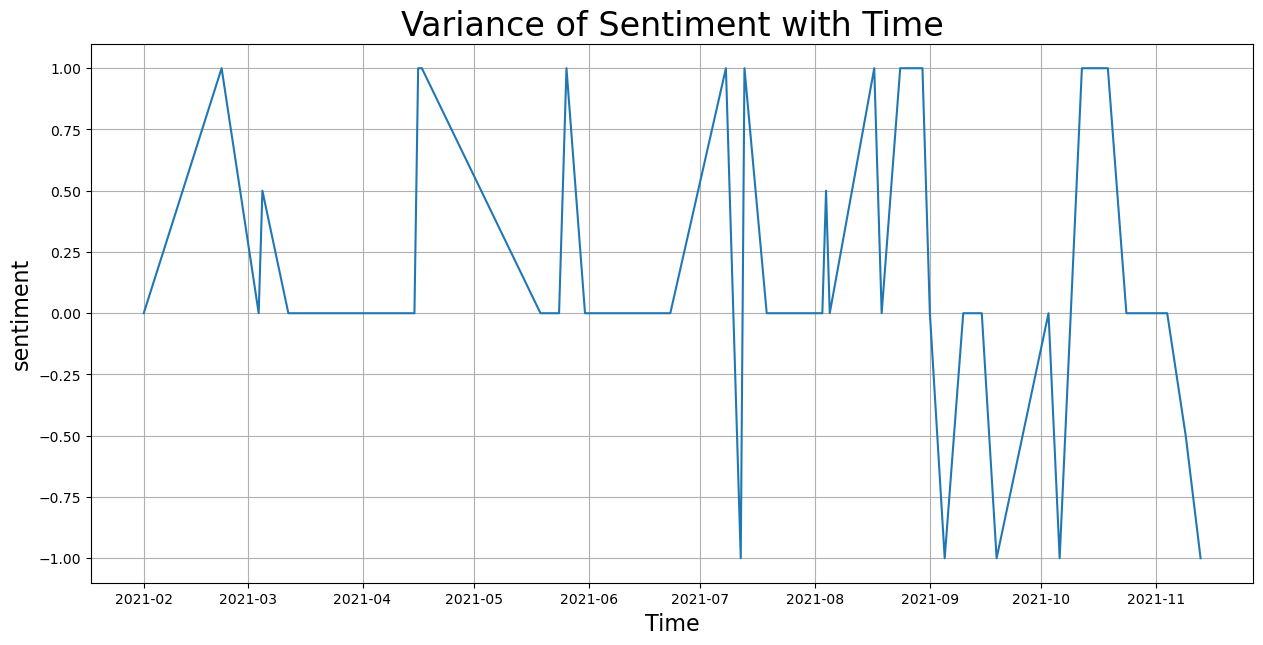

In [58]:
country_time_variance("finland")

## Denmark

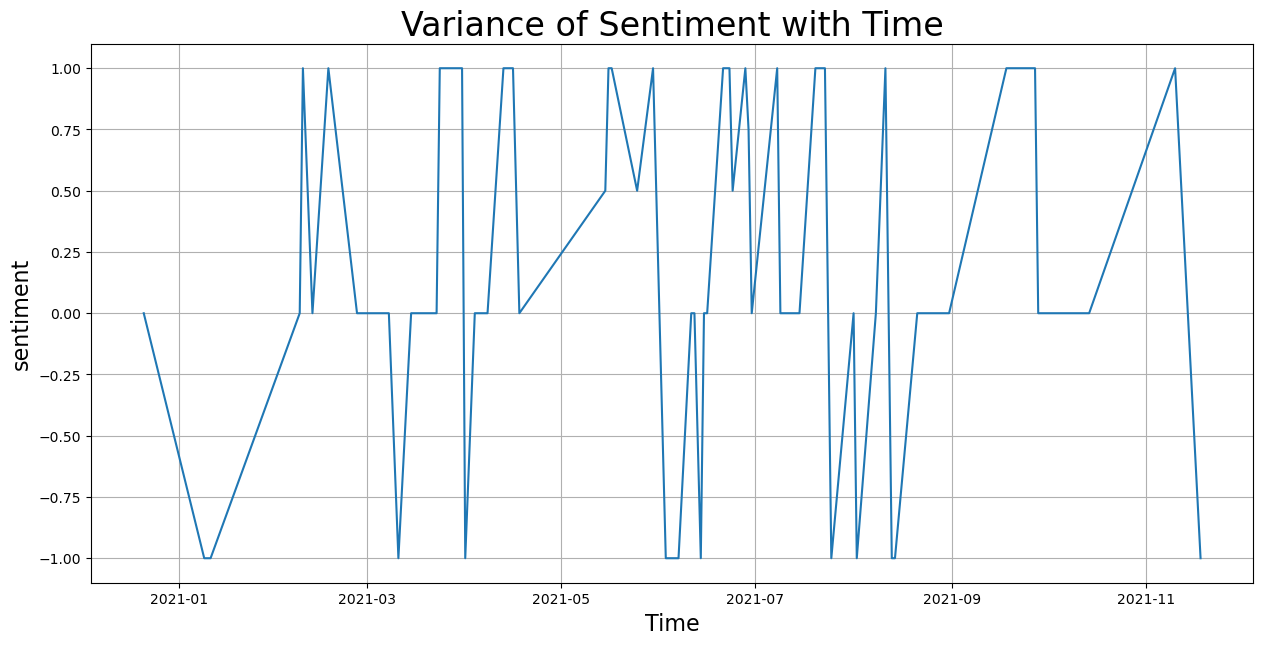

In [59]:
country_time_variance("denmark")

# Mean Sentiments

## Vaccines

Text(0.5, 1.0, 'Mean Sentiment of Vaccines')

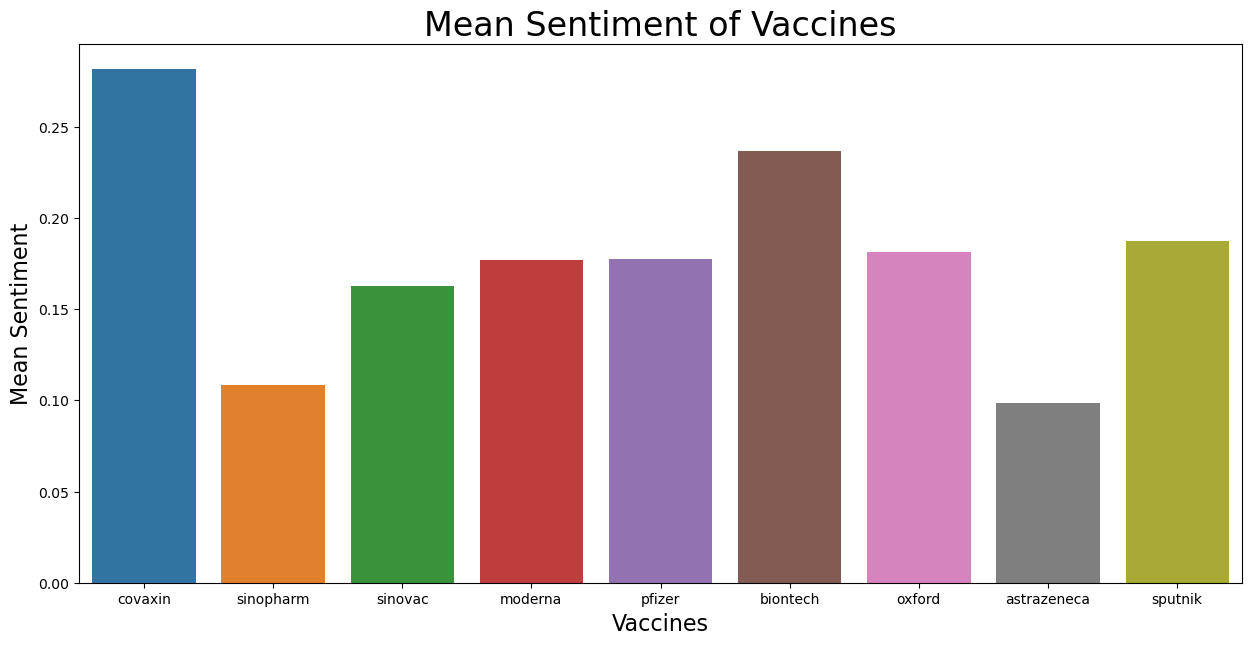

In [60]:
vax_sentiment["sentiment"]=sentiments

fg,axs=plt.subplots(figsize=(15,7))
sns.barplot(ax=axs,x="Vaccine",y="sentiment",data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Vaccines",size=24)

In [61]:
country_sentiment=pd.DataFrame()
countries=["sweden","usa","uk","norway","finland","denmark","germany","canada","russia","italy","australia","france","argentina","uae","israel","mexico","japan", "india", "china"]
country_sentiment['countries']=countries
senti=list()

for country in countries :
    senti.append(vax[vax["user_location"].str.lower().str.contains(country)].sentiment.mean())
    
country_sentiment["sentiment"]=senti

## Countries

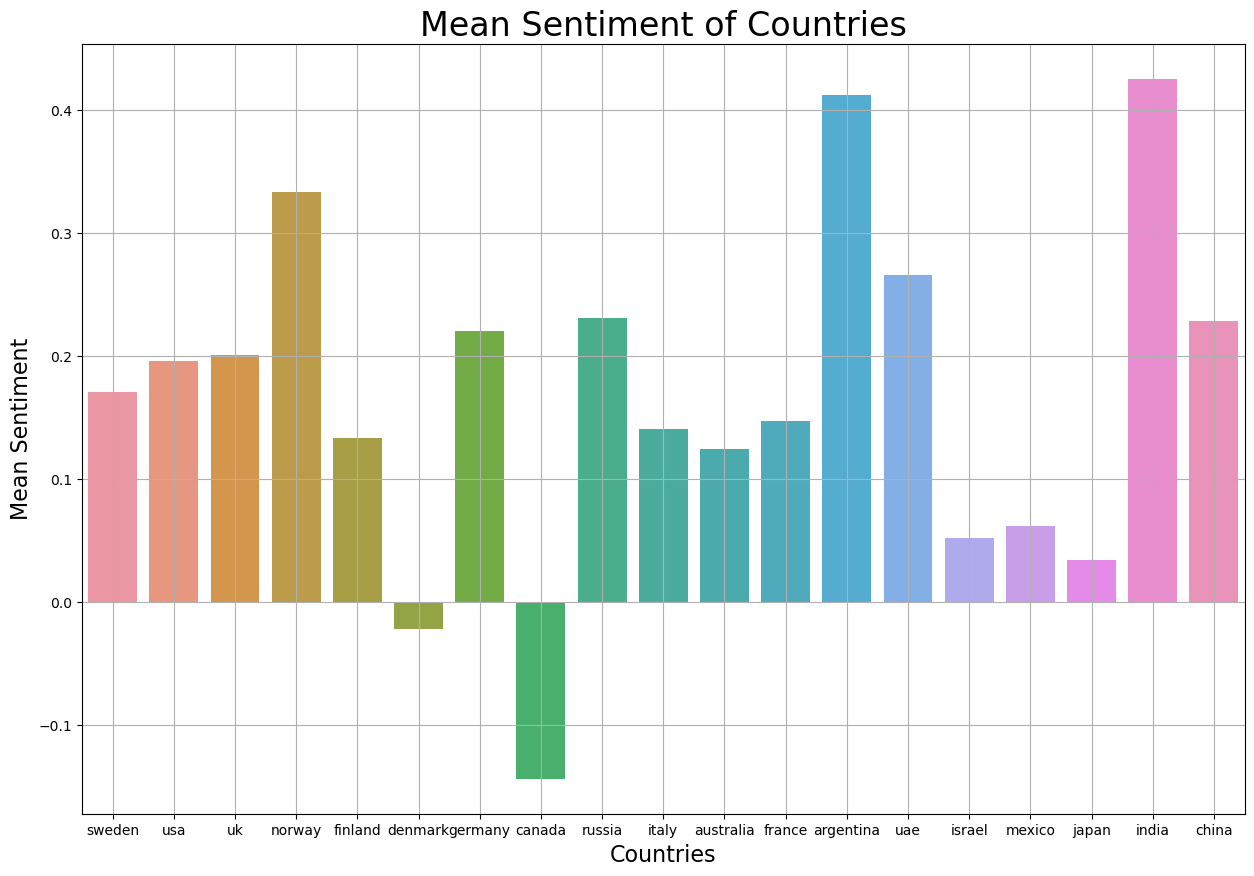

In [62]:
fg,axs=plt.subplots(figsize=(15,10))
sns.barplot(ax=axs,x="countries",y="sentiment",data=country_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Countries",size=24)
axs.grid()

# CONCLUSION

[Data used for this notebook](https://www.kaggle.com/datasets/gpreda/all-covid19-vaccines-tweets/data)

This analysis only shows sentiments on Twitter during a limited time period (2020-12-12 - 2021-11-23). This notebook only represents sentiments on Twitter during this time, and does not reflect all social media platforms nor possible change in sentiments during other time periods.

As shown in the [Distrubution of Sentiments Chart](#Distrubution-of-Sentiments-Chart), there is an uneven distribution of sentiments, with neutral taking the highest portion of the total percentage. Positive sentiments follow closely after, while negative sentiments hold a significantly lower percentage.

The [Positive Sentiment N grams](#Positive-Sentiment-N-grams) seem to mainly contain Tweets about the availability and approval of Covid vaccines, possibly particularly in rural areas since mentions of rural and urban is present in all positive N-grams. India is also frequently mentioned. Another common theme in the positive sentiment tweets is people sharing that they got vaccinated.

[Negative Sentiment N grams](#Negative-Sentiment-N-grams) show a big number of Tweets about Canada and India. These N-grams seem to mainly contain concerns about health, death and side effects of the vaccines. They also seem to contain reports of death cases. Mentions of lockdowns and staying at home is unique to the trigram in this category.

Similar to previous N-grams, [Neutral Sentiment N grams](#Neutral-Sentiment-N-grams) contain many Tweets about India and Canada, but also Russia and China. The Tweets in this category seem to mainly report the spread of the virus. Like the positive sentiment N-grams, there are many who post about getting vaccinated.

As seen in both the graphs for [variance with time for vaccines](#All-Vaccines) and [variance with time for countries](#Sweden), the variance in sentiments are quite erratic, some more so than others. Most of these graphs show big spikes between positive and negative sentiments, and rarely any stable values.
It is worth pointing out that all of these graphs only reflect early 2021 to Nov 2021. 

Lastly, the [Mean Sentiments of Countries](#Countries) show a great variance between sentiments of different countries. One that stands out in particular is Canada, which scores significantly lower than other countries in the chart. This may correlate with the frequent mentions of Canada in the negative sentiment N-grams.